In [5]:
#Simple nu-O event generator for 10s-of-MeV neutrinos
#Follows approach taken by NEWTON
#
#Steps:
# Supply total xs (different choices)
# Supply partial xs, normalize to total
# Specify neutrino flux, fold with XS, sample
# Sample partial xs based on sampled neutrino energy
# Calculate lepton energy, direction, nuclear recoil
# Draw from pre-computed TALYS de-excitation files to generate events
import numpy as np
import matplotlib.pyplot as plt

interpolationStep_MeV = 0.001 #Interpolate digitized plots with this precision
maxEnergy_MeV = 52.9
energies_MeV_interp = np.arange(0,maxEnergy_MeV,interpolationStep_MeV)

#total_xs_name = "data/total_xs/Haxton1987.csv"
total_xs_name = "data/total_xs/Kolbe2002.csv"

partial_xs_name = "data/partial_xs/Nakazato2018.csv"
outputFormat = "root" #root, ascii

#Constants
#AME 20 mass evaluations: https://www.anl.gov/sites/www/files/2021-05/mass_1.mas20.txt
mass_16O_amu = 15994914.61926e-6 #includes 8 electrons
mass_16F_amu = 16011460.278e-6 #includes 9 electrons
amu_to_MeV = 931.49432

#(160 + 8 electrons) + nu_e -> (16F + 8 electrons) + 1 electron 
threshold = (mass_16F_amu-mass_16O_amu)*amu_to_MeV
print(f"Threshold of 16O CC process is {threshold:.3f} MeV")

Threshold of 16O CC process is 15.412 MeV


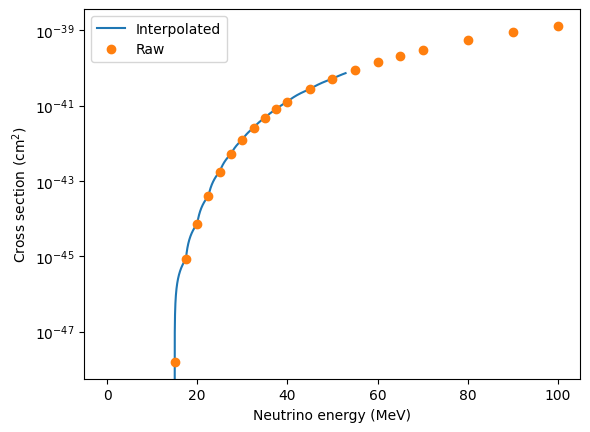

In [6]:
#1. Load total xs
def loadCSV(fname):
  energies_MeV_raw = []
  xs_cm2_raw = []
  for line in open(fname,"r"):
    if not line.startswith("#"):
      line=line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        if len(lineParts)==2:
          energies_MeV_raw.append(float(lineParts[0]))
          xs_cm2_raw.append(float(lineParts[1]))
  

  return energies_MeV_raw,xs_cm2_raw

energies_MeV_raw,xs_cm2_raw = loadCSV(total_xs_name)
xs_cm2_interp = np.interp(energies_MeV_interp,energies_MeV_raw,xs_cm2_raw,left=0,right=energies_MeV_raw[-1])

plt.plot(energies_MeV_interp,xs_cm2_interp,label="Interpolated")
plt.plot(energies_MeV_raw,xs_cm2_raw,ls="",marker="o",label="Raw")
plt.legend()
plt.xlabel("Neutrino energy (MeV)")
plt.ylabel("Cross section (cm$^2$)")
plt.yscale("log")


In [ ]:
#Load partial cross sections
def loadNazakatoData(fname):
  excitedLevels_MeV = []
  excitedLevels_J = []
  excitedLevels_parity = []
  excitedXS_20MeV = []
  excitedXS_40MeV = []
  excitedXS_60MeV = []
  for line in open(fname,"r"):
    if not line.startswith("#"):
      line=line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        if len(lineParts)==6:
          excitedLevels_MeV.append(float(lineParts[0]))
          excitedLevels_J.append(int(lineParts[1]))
          excitedLevels_parity.append(int(lineParts[2]))
          excitedXS_20MeV.append(float(lineParts[3]))
          excitedXS_40MeV.append(float(lineParts[4]))
          excitedXS_60MeV.append(float(lineParts[5]))
  
  #FIT COEFFICIENTS
  excitedLevels_MeV = np.asarray(excitedLevels_MeV)

  return excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV
  
excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV = loadNazakatoData(partial_xs_name)


In [ ]:
#Solve for coefficients
def solveCoeffs(excitedLevels_MeV,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV):
  c1s = []
  c2s = []
  c3s = []
  #Now step through levels, computing nu xs by fitting the three data files to determine coefficients a,b,c. Then
  for ilev,excitedLevel_MeV in enumerate(excitedLevels_MeV):

    Ex = excitedLevel_MeV + threshold #Defined relative to 16O state
    if Ex < 20:
      Lambda_20MeV = np.log10(np.power(20,0.25)-np.power(Ex,0.25))
    else:
      Lambda_20MeV = 0
    if Ex < 40:
      Lambda_40MeV = np.log10(np.power(40,0.25)-np.power(Ex,0.25))
    else:
      Lambda_40MeV = 0
    if Ex < 60:
      Lambda_60MeV = np.log10(np.power(60,0.25)-np.power(Ex,0.25))
    else:
      Lambda_60MeV = 0

    if excitedXS_20MeV[ilev]>0:
      logxs_20MeV = np.log10(excitedXS_20MeV[ilev])
    else:
      logxs_20MeV = 0
    if excitedXS_40MeV[ilev]>0:
      logxs_40MeV = np.log10(excitedXS_40MeV[ilev])
    else:
      logxs_40MeV = 0
    if excitedXS_60MeV[ilev]>0:
      logxs_60MeV = np.log10(excitedXS_60MeV[ilev])
    else:
      logxs_60MeV = 0

    if logxs_20MeV==0:
      A = np.array([[1.0,Lambda_40MeV],
                  [1.0,Lambda_60MeV]])
      y = np.array([logxs_40MeV,logxs_60MeV])
      a,b = np.linalg.solve(A,y)
      c = 0
    else:
      A = np.array([[1.0,Lambda_20MeV,Lambda_20MeV*Lambda_20MeV],
                  [1.0,Lambda_40MeV,Lambda_40MeV*Lambda_40MeV],
                  [1.0,Lambda_60MeV,Lambda_60MeV*Lambda_60MeV]])
      y = np.array([logxs_20MeV,logxs_40MeV,logxs_60MeV])
      a,b,c = np.linalg.solve(A,y)

    c1s.append(a)
    c2s.append(b)
    c3s.append(c)

  return c1s,c2s,c3s
  
c1s,c2s,c3s = solveCoeffs(excitedLevels_MeV,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV)

      


In [ ]:
#Now calculate partial_xs
partial_xs = []
for ilev,excitedLevel_MeV in excitedLevels_MeV:
  if c3s[ilev]==0:
    for E in energies_MeV_interp:
      